In [63]:
#importing relevant packages
from google.cloud import bigquery
from google.oauth2 import service_account
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from haversine import haversine, Unit
from sklearn.metrics import silhouette_samples, silhouette_score
import folium
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import clhs as cl
%matplotlib inline

In [64]:
#Loading geo_census data
file = 'geo_census.csv'
data = pd.read_csv(file)
data.head()

,d,s,p,pop,hhs,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


### Feature Engineering

In [65]:
data.columns

Index(['d', 's', 'p', 'pop', 'hhs', 'fem_hhs', 'long', 'lat', 'km2', 'area',
       'perimeter', 'T123', 'not_T123', 'light_gas_pc', 'light_gas_per_km',
       'light_lpg_pc', 'light_lpg_per_km', 'light_biogas_pc',
       'light_biogas_per_km', 'light_par_lantern_pc',
       'light_par_lantern_per_km', 'light_par_tadooba_pc',
       'light_par_tadooba_per_km', 'light_candles_pc', 'light_candles_per_km',
       'light_firewood_pc', 'light_firewood_per_km', 'light_cow_dung_pc',
       'light_cow_dung_per_km', 'light_grass_pc', 'light_grass_per_km',
       'cook_elec_therm_pc', 'cook_elec_therm_per_km', 'cook_gas_pc',
       'cook_gas_per_km', 'cook_lpg_pc', 'cook_lpg_per_km', 'cook_biogas_pc',
       'cook_biogas_per_km', 'cook_par_lantern_pc', 'cook_par_lantern_per_km',
       'cook_charc_pc', 'cook_charc_per_km', 'cook_firewood_pc',
       'cook_firewood_per_km', 'cook_dung_pc', 'cook_dung_per_km',
       'cook_grass_pc', 'cook_grass_per_km', 'waste_burn_pc',
       'waste_burn_per_km'

In [66]:
data.shape

(116, 66)

In [67]:
#dropping columns with _pc in their names
for column in data.columns:
    if '_pc' in column:
        data.drop(column, axis = 1, inplace = True)
data.head()

,d,s,p,pop,hhs,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [68]:
#Renaming some columns for better understandability
data.rename(columns = {'d': 'district', 's': 'subcounty', 'p':'parish', 'pop':'population', 'hhs':'households'}, inplace = True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [69]:
#Drop rows with null values
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [70]:
#setting number of samples
n = 20
#data to be used for sampling
X = data[['light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]
X.head()

,light_par_tadooba_per_km,light_firewood_per_km,light_cow_dung_per_km,light_grass_per_km,cook_charc_per_km,cook_firewood_per_km,cook_dung_per_km,cook_grass_per_km,waste_burn_per_km,kitch_outside_built_per_km,kitch_make_shift_per_km,kitch_open_space_per_km,pop_density,hhs_density,T123_per_sqkm
0,92.37,2.09,0.00,0.10,1220.60,89.99,0.1,0.0,1001.49,509.36,74.56,490.22,5813.62,1405.81,10.85
1,11.66,0.19,0.00,0.05,95.64,25.93,0.0,0.0,79.32,55.84,11.66,35.28,605.86,136.01,3.44
2,33.02,2.06,0.00,0.00,1069.40,52.97,0.0,0.0,324.71,345.00,46.78,454.04,5818.23,1546.83,13.83
3,0.56,0.00,0.00,0.00,58.32,1.11,0.0,0.0,203.83,157.18,2.78,1.67,7666.06,746.45,9.14
4,1.11,0.00,0.37,0.00,289.19,12.25,0.0,0.0,109.88,46.03,13.36,88.35,1951.55,503.39,15.48


### Functions to be used

In [71]:
def correlation_matrix_2(df):
    '''
    Plots correlation matrix of a dataframe
    '''
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Abalone Feature Correlation')
    labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()
    
def correlation_matrix_1(df):
    '''
    Plots correlation matrix of a dataframe
    '''
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    #Random Sampling Correlation Matrix
    f = plt.figure(figsize=(5, 5))
    plt.matshow(random_samples.corr(), fignum=f.number)
    #plt.xticks(range(random_samples.shape[1]), random_samples.columns, fontsize=14, rotation=45)
    #plt.yticks(range(random_samples.shape[1]), random_samples.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)

def preprocessing(parish):
    '''
    reads and preprocesses data
    '''
    #file path where device data is 
    feeds_path = r'D:\AirQo\sensor location model\feeds'
    channel_id = parish_sensor_dict[parish]
    
    #query_string = "SELECT created_at, pm2_5 FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id = %d" %channel_id    
    #bqdata = bqclient.query(query_string).result()
    #data= bqdata.to_dataframe()
    data = pd.read_csv(feeds_path + '\\' + str(channel_id)+'.csv', 
                       usecols = ['created_at', 'field1'],
                       parse_dates=['created_at'])
    
    #renaming field1
    new_name = parish +'_PM2_5'
    data.rename(columns = {'field1':new_name}, inplace = True) 
    
    #data in ascending order
    data = data.sort_values(by = 'created_at', ascending=True)
    
    #setting the datetime column as the index
    data.set_index('created_at', inplace=True)
    
    #hourly data
    hourly_data = data.resample('H').mean().round(2)  
    
    #dropping rows with null values
    final_data=hourly_data.dropna()
    
    return final_data

def merge_dfs(df_list):
    '''
    Merges several dataframes into one based on the index
    '''
    final_df = reduce(lambda left,right: pd.merge(left,right,on='created_at'), df_list)
    return final_df

def find_correlation(data, column1, column2):
    '''
    Finds the correlation between 2 different columns in a dataframe
    '''
    correlation = data[column1].corr(data[column2])
    return correlation

def generate_category(row):
    if row['average pm2_5']>=0.0 and row['average pm2_5']<=12.0:
        return 'Good'
    elif row['average pm2_5']>=12.1 and row['average pm2_5']<=35.4:
        return 'Moderate'
    elif row['average pm2_5']>=35.5 and row['average pm2_5']<=55.4:
        return 'Unhealthy for Sensitive Groups'
    elif row['average pm2_5']>=55.5 and row['average pm2_5']<=150.4:
        return 'Unhealthy'
    elif row['average pm2_5']>=150.5 and row['average pm2_5']<=250.4:
        return 'Very Unhealthy'
    elif row['average pm2_5']>=250.5 and row['average pm2_5']<=500.4:
        return 'Hazardous'

### Random Sampling

In [72]:
random_samples = data.sample(n)
random_samples.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
24,KAMPALA,NAKAWA DIVISION,MUTUNGO,64663,17343,28.4,32.642221,0.316613,4.482538,4.442810,...,1462.79,14425.53,3869.01,3.73,14.72,12.86,0.10,0.09,"POLYGON((32.6294565351959 0.317619091417548, 3...",POINT(32.6422210737128 0.316613228968423)
98,KAMPALA,MAKINDYE DIVISION,KIBUYE II,9051,2666,36.9,32.572704,0.289880,0.428981,0.425281,...,3135.34,21098.84,6214.73,3.39,50.42,10.72,0.24,0.05,"POLYGON((32.5774179045475 0.28897182151738, 32...",POINT(32.5727043802384 0.289879752219056)
63,KAMPALA,KAWEMPE DIVISION,WANDEGEYA,7130,2585,42.2,32.573928,0.334670,0.360497,0.357386,...,3195.59,19778.23,7170.65,2.76,29.11,16.53,0.15,0.08,"POLYGON((32.5767400921726 0.333998439234469, 3...",POINT(32.5739276942618 0.334670079868604)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
72,KAMPALA,KAWEMPE DIVISION,MAKERERE III,11819,3783,36.0,32.567430,0.350266,0.632303,0.626861,...,3269.00,18691.98,5982.89,3.12,24.52,8.87,0.13,0.05,"POLYGON((32.5708362242945 0.347891833670545, 3...",POINT(32.567429953885 0.350266186003449)


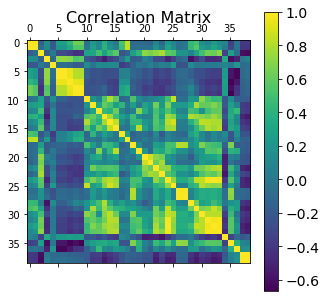

In [73]:
correlation_matrix_1(random_samples)

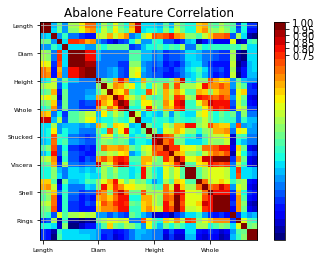

In [74]:
correlation_matrix_2(random_samples)

### Latin Hypercube Sampling

In [75]:
sampled = cl.clhs(X, , max_iterations=1000)
clhs_samples =data.iloc[sampled['sample_indices']]
clhs_samples.head()

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\user\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
cLHS:100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|1000/1000 [Elapsed time: 3.9637489318847656, ETA: 0.0, 252.29it/s]


,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
96,KAMPALA,MAKINDYE DIVISION,GGABA,24408,6261,35.1,32.636660,0.264221,13.191575,13.074920,...,206.27,1850.27,474.62,3.90,6.24,5.38,0.34,0.29,"POLYGON((32.6400109034108 0.279719589327621, 3...",POINT(32.6366600555401 0.264221055635468)
41,KAMPALA,CENTRAL DIVISION,NAKASERO I,618,250,21.6,32.585490,0.321403,0.638290,0.632757,...,31.33,968.21,391.67,2.47,33.19,20.03,3.43,2.07,"POLYGON((32.5912230400381 0.319282119046764, 3...",POINT(32.585489725416 0.321402566367857)
109,WAKISO,BUNAMWAYA DIVISION,BUNAMWAYA,32549,8293,29.4,32.555615,0.255076,5.732152,5.683044,...,493.01,5678.32,1446.75,3.92,15.27,10.83,0.27,0.19,"POLYGON((32.5454103015193 0.240370313949034, 3...",POINT(32.5556147202207 0.25507614594765)
92,KAMPALA,MAKINDYE DIVISION,NSAMBYA POLICE BARRACKS,7512,1700,20.2,32.590484,0.305946,0.478735,0.474577,...,45.95,15691.34,3551.02,4.42,22.11,13.33,0.14,0.08,"POLYGON((32.5955900585179 0.302352389459196, 3...",POINT(32.5904835777286 0.305946009347377)
62,KAMPALA,KAWEMPE DIVISION,BWAISE III,8183,2446,36.9,32.558130,0.349867,0.535491,0.530899,...,1966.42,15281.30,4567.77,3.35,33.38,17.40,0.22,0.11,"POLYGON((32.5540159110247 0.351830440904876, 3...",POINT(32.5581303849542 0.349867451145511)


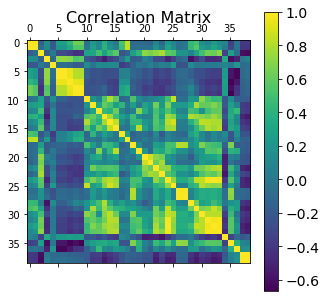

In [76]:
correlation_matrix_1(clhs_samples)

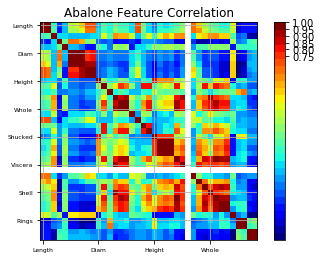

In [77]:
correlation_matrix_2(clhs_samples)

### K-Means Clustering

In [78]:
#extracting x, y and z coordinates to replace latitude and longitude 
data['coord_x'] = np.cos(data['lat']) * np.cos(data['long'])
data['coord_y'] = np.cos(data['lat']) * np.sin(data['long'])
data['coord_z'] = np.sin(data['lat'])
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009),0.427272,0.834188,0.348667
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685),0.324676,0.899089,0.293641
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761


In [79]:
# perform normalization on input features and present as dataframe
X_scaled = StandardScaler().fit_transform(X)

In [80]:
# running the kmeans model
kmeans = KMeans(n_clusters = n).fit(X_scaled) 

# predicting which cluster each sample will appear in as an array
y_kmeans = kmeans.fit_predict(X_scaled)

#adding a cluster column to the geo_census data
data['cluster'] = y_kmeans
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009),0.427272,0.834188,0.348667,5
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290,13
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595,5
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685),0.324676,0.899089,0.293641,13
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761,13


In [81]:
#selecting one parish per cluster
kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
kmeans_samples.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster
4,KAMPALA,KAWEMPE DIVISION,MULAGO II,14493,4769,38.0,32.574052,0.344265,0.502444,0.498108,...,21.07,12.23,0.07,0.04,"POLYGON((32.5777577389499 0.347328057402734, 3...",POINT(32.5740518706938 0.344264758122724),0.377525,0.862302,0.337505,9
10,KAMPALA,MAKINDYE DIVISION,KATWE II,13492,3729,35.3,32.579199,0.301609,0.527916,0.523351,...,19.39,13.78,0.08,0.05,"POLYGON((32.5824692688573 0.302922199190013, 3...",POINT(32.5791988291749 0.301608654391697),0.378447,0.876662,0.297057,17
11,KAMPALA,MAKINDYE DIVISION,KIBUYE II,9051,2666,36.9,32.572704,0.289880,0.428981,0.425281,...,50.42,10.72,0.24,0.05,"POLYGON((32.5774179045475 0.28897182151738, 32...",POINT(32.5727043802384 0.289879752219056),0.385507,0.877315,0.285837,8
29,KAMPALA,MAKINDYE DIVISION,KATWE I,7867,2234,36.3,32.574835,0.298327,0.303625,0.301004,...,36.52,15.66,0.14,0.06,"POLYGON((32.576551860597 0.30124676041233, 32....",POINT(32.5748348179421 0.298326623279696),0.382657,0.875890,0.293921,14
54,KAMPALA,MAKINDYE DIVISION,WABIGALO,15265,4317,27.6,32.603186,0.311770,0.638607,0.633032,...,21.09,12.74,0.09,0.05,"POLYGON((32.6011170046815 0.306462938501432, 3...",POINT(32.6031864743015 0.311769788730856),0.356163,0.882642,0.306744,10


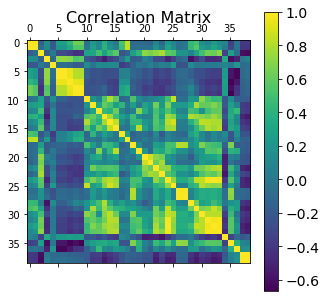

In [82]:
correlation_matrix_1(kmeans_samples)

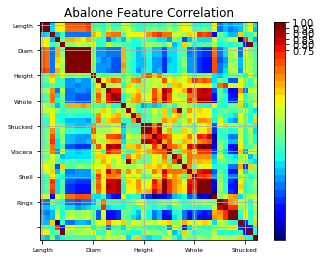

In [83]:
correlation_matrix_2(kmeans_samples)

### Gaussian Process

In [84]:
#dictionary with parish names as keys and device ids as values
parish_sensor_dict = {'NTINDA':930434, 'BUGOLOBI':718028, 'NANTABULIRWA':912224, 'KIREKA':930426, 'LUWAFU':930427, 
                     'BANDA':912223, 'MBUYA II':912222, 'NAKASERO II':912220, 'KIWATULE':870145, 'KYALIWAJJALA':870143,
                     'BUTABIKA':870144, 'NANSANA WEST':870147, 'NANSANA EAST':870142, 'BUSEGA':870139, 'KYANJA':832255,
                     'BUSABALA':832252, 'BUNAMWAYA':832253, 'KYEBANDO':832254, 'LUKULI':832251, 'BUKOTO I':782720,
                     'KANSANGA':782719, 'KASUBI':782718, 'NAGURU II':755614, 'MAKINDYE I':755612,
                     'MAKERERE UNIVERSITY':870146, 'LUBAGA':737276, 'BWEYOGERERE':737273, 'CIVIC CENTRE':689761}

In [85]:
#forming the dataset
gp_data = pd.DataFrame()

In [86]:
#creating the X portion of the dataset
gp_data = pd.DataFrame()
for parish in data['parish']:
    if parish in parish_sensor_dict.keys():
        if parish != 'KYEBANDO':
            #print ('Appending ....', parish)
            gp_data = gp_data.append(data[data['parish']==parish])
        else:
            pass
gp_data = gp_data.append(data.loc[(data['parish']== 'KYEBANDO') & (data['district']=='KAMPALA')])
gp_data.shape

(28, 48)

In [87]:
#creating the y portion of the dataset
gp_data['average pm2_5']= ''
gp_data['category'] = ''

#dictionary with all 28 parishes as keys and their dataframes as values
all_gp_dict = {}
for parish in gp_data['parish']:
    all_gp_dict[parish]= preprocessing(parish)

In [88]:
#filling in average pm2_5 column
for parish in all_gp_dict.keys():
    column_name = parish+'_PM2_5'
    gp_data.loc[gp_data.parish == parish, 'average pm2_5'] = all_gp_dict[parish][column_name].mean()
gp_data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster,average pm2_5,category
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290,13,33.4191,
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595,5,62.8261,
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761,13,52.14,
12,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),0.356997,0.867801,0.345652,7,61.9877,
15,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),0.338976,0.889579,0.306178,13,44.273,


In [89]:
#filling in category column
gp_data['category'] = gp_data.apply (lambda row: generate_category(row), axis=1)

In [90]:
gp_data.to_csv(r'gp_data.csv', index = False)

In [28]:
gp_data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster,average pm2_5,category
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290,17,33.4191,Moderate
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595,15,62.8261,Unhealthy
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761,17,52.14,Unhealthy for Sensitive Groups
12,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),0.356997,0.867801,0.345652,7,61.9877,Unhealthy
15,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),0.338976,0.889579,0.306178,17,44.273,Unhealthy for Sensitive Groups


In [42]:
# Instantiate a Gaussian Process model
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)

##### using all features

In [48]:
#X = gp_data.drop(['district', 'subcounty', 'parish', 'population', 'households''average pm2_5'], axis = 1)
X_gp = gp_data[['light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]
#y_gp = gp_data['average pm2_5']
y_gp=gp_data['category']
y_gp

1                            Moderate
2                           Unhealthy
4      Unhealthy for Sensitive Groups
12                          Unhealthy
15     Unhealthy for Sensitive Groups
16     Unhealthy for Sensitive Groups
17     Unhealthy for Sensitive Groups
20                          Unhealthy
21                          Unhealthy
23     Unhealthy for Sensitive Groups
29                          Unhealthy
30                          Unhealthy
33                          Unhealthy
43     Unhealthy for Sensitive Groups
46                          Unhealthy
61     Unhealthy for Sensitive Groups
79     Unhealthy for Sensitive Groups
85                          Unhealthy
87                          Unhealthy
91                          Unhealthy
95                          Unhealthy
101    Unhealthy for Sensitive Groups
103                         Unhealthy
109                         Unhealthy
110                         Unhealthy
111                         Unhealthy
112         

In [51]:
#Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_gp, y_gp, test_size=0.2, shuffle=True)

In [54]:
#Fit to data using Maximum Likelihood Estimation of the parameters
gpc.fit(X_train, y_train)

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=0,
                          warm_start=False)

In [57]:
print(X_train.shape)
print(X_test.shape)

(22, 15)
(6, 15)


In [55]:
#Make predictions for testing data
#y_pred, sigma = gp.predict(X_test, return_std=True)
y_pred = gpc.predict(X_test)
y_pred

array(['Unhealthy for Sensitive Groups', 'Unhealthy for Sensitive Groups',
       'Unhealthy for Sensitive Groups', 'Unhealthy for Sensitive Groups',
       'Unhealthy for Sensitive Groups', 'Unhealthy for Sensitive Groups'],
      dtype='<U30')

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print ('Accuracy: ',accuracy_score(y_test, y_pred))
print ('Precision: ',precision_score(y_test, y_pred, average =None))
print ('Recall: ',recall_score(y_test, y_pred, average=None))

Accuracy:  0.3333333333333333
Precision:  [0.         0.33333333]
Recall:  [0. 1.]


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt

#rmse = sqrt(mean_squared_error(y_test, y_pred))
#rmse

In [ ]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X, return_std=True)

### Plotting Results

In [ ]:
#Converting to a Geodataframe
data['geometry'] = data['geometry'].apply(wkt.loads)
geo_data = gpd.GeoDataFrame(data, geometry = data['geometry'])
geo_data.head()

In [ ]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Comparison between three methods' 
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
geo_data.plot(column='pop_density',ax = ax, legend = True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (geo_data.long[i], geo_data.lat[i]))
plt.scatter(random_samples.long, random_samples.lat, s=300, c='g')
plt.scatter(clhs_samples.long, clhs_samples.lat, s=300, c='b')
plt.scatter(kmeans_samples.long, kmeans_samples.lat, s=300, c='r')
plt.show()
#fig.savefig('First Sensor Locations.png')

### Using data from currently installed devices

In [ ]:
random_data_dict = {}
for parish in random_samples['parish']:
    if parish in parish_sensor_dict.keys():
        data = preprocessing(parish)
        random_data_dict[parish]=data

In [ ]:
clhs_data_dict = {}
for parish in clhs_samples['parish']:
    if parish in parish_sensor_dict.keys():
        data = preprocessing(parish)
        clhs_data_dict[parish]=data

In [ ]:
kmeans_data_dict = {}
for parish in kmeans_samples['parish']:
    if parish in parish_sensor_dict.keys():
        data = preprocessing(parish)
        print(parish, 'done!')
        kmeans_data_dict[parish]=data

In [ ]:
# lists of dataframes for respective methods
random_merged_df =merge_dfs(list(random_data_dict.values()))
clhs_merged_df =merge_dfs(list(clhs_data_dict.values()))
kmeans_merged_df =merge_dfs(list(kmeans_data_dict.values()))

In [ ]:
random_corr =random_merged_df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(random_corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(random_merged_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(random_merged_df.columns)
ax.set_yticklabels(random_merged_df.columns)
plt.show()

In [ ]:
clhs_corr =clhs_merged_df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(clhs_corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(clhs_merged_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(clhs_merged_df.columns)
ax.set_yticklabels(clhs_merged_df.columns)
plt.show()

In [ ]:
kmeans_corr =kmeans_merged_df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(kmeans_corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(kmeans_merged_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(kmeans_merged_df.columns)
ax.set_yticklabels(kmeans_merged_df.columns)
plt.show()